 # What is it like to be a learning machine

In [ ]:
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches

from ipywidgets import interact, Checkbox, IntSlider, SelectionSlider


plt.rcParams['figure.dpi'] = 300
COLOR1 = 'firebrick'
COLOR2 = 'olivedrab'

 # What is learning like?

In [ ]:
rng = np.random.RandomState(seed=0)
barcode_size = 100
decision_boundary = 25
padding = 2
X = []
y = []
codes = []
for _ in range(1000):
    # Generate a random sequence of 0's and 1's
    code = rng.choice([0, 1], size=barcode_size)

    # Find the number of consecutive 1's (i.e., bars)
    diff = np.diff(np.concatenate(([0], code, [0])))
    n_bars = len(np.where(diff == 1)[0])

    # Let's make the separation more obvious
    if decision_boundary - padding <= n_bars <= decision_boundary + padding:
        continue

    X.append(n_bars)
    y.append(n_bars > decision_boundary)
    codes.append(code)


# Make an equal number of samples per class
X = np.array(X)
y = np.array(y)
codes = np.array(codes)

n_class1 = y.sum()
n_class2 = np.logical_not(y).sum()
n_samples = min(n_class1, n_class2)
inds = np.arange(len(y))
inds1 = rng.choice(inds[y], size=n_samples, replace=False)
inds2 = rng.choice(inds[~y], size=n_samples, replace=False)
sel = np.sort(np.concatenate([inds1, inds2]))

X = X[sel]
y = y[sel]
codes = codes[sel]

# Create colormaps for two classes
class1 = matplotlib.colors.ListedColormap(['white', COLOR1])
class2 = matplotlib.colors.ListedColormap(['white', COLOR2])


@interact(index=IntSlider(min=0, max=len(codes) * 2, value=0))
def plot_barcode(index):
    """Adapted from matplotlib examples"""

    i = index // 2
    code = codes[i]
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect=2)
    ax.set_axis_off()

    if index % 2:
        cmap = class2 if y[i] else class1
    else:
        cmap = 'binary'
    ax.imshow(code.reshape(1, -1), cmap=cmap, aspect='auto')

interactive(children=(IntSlider(value=0, description='index', max=508), Output()), _dom_classes=('widget-inter…

 # How do machines learn to classify?

 ## Plot our samples

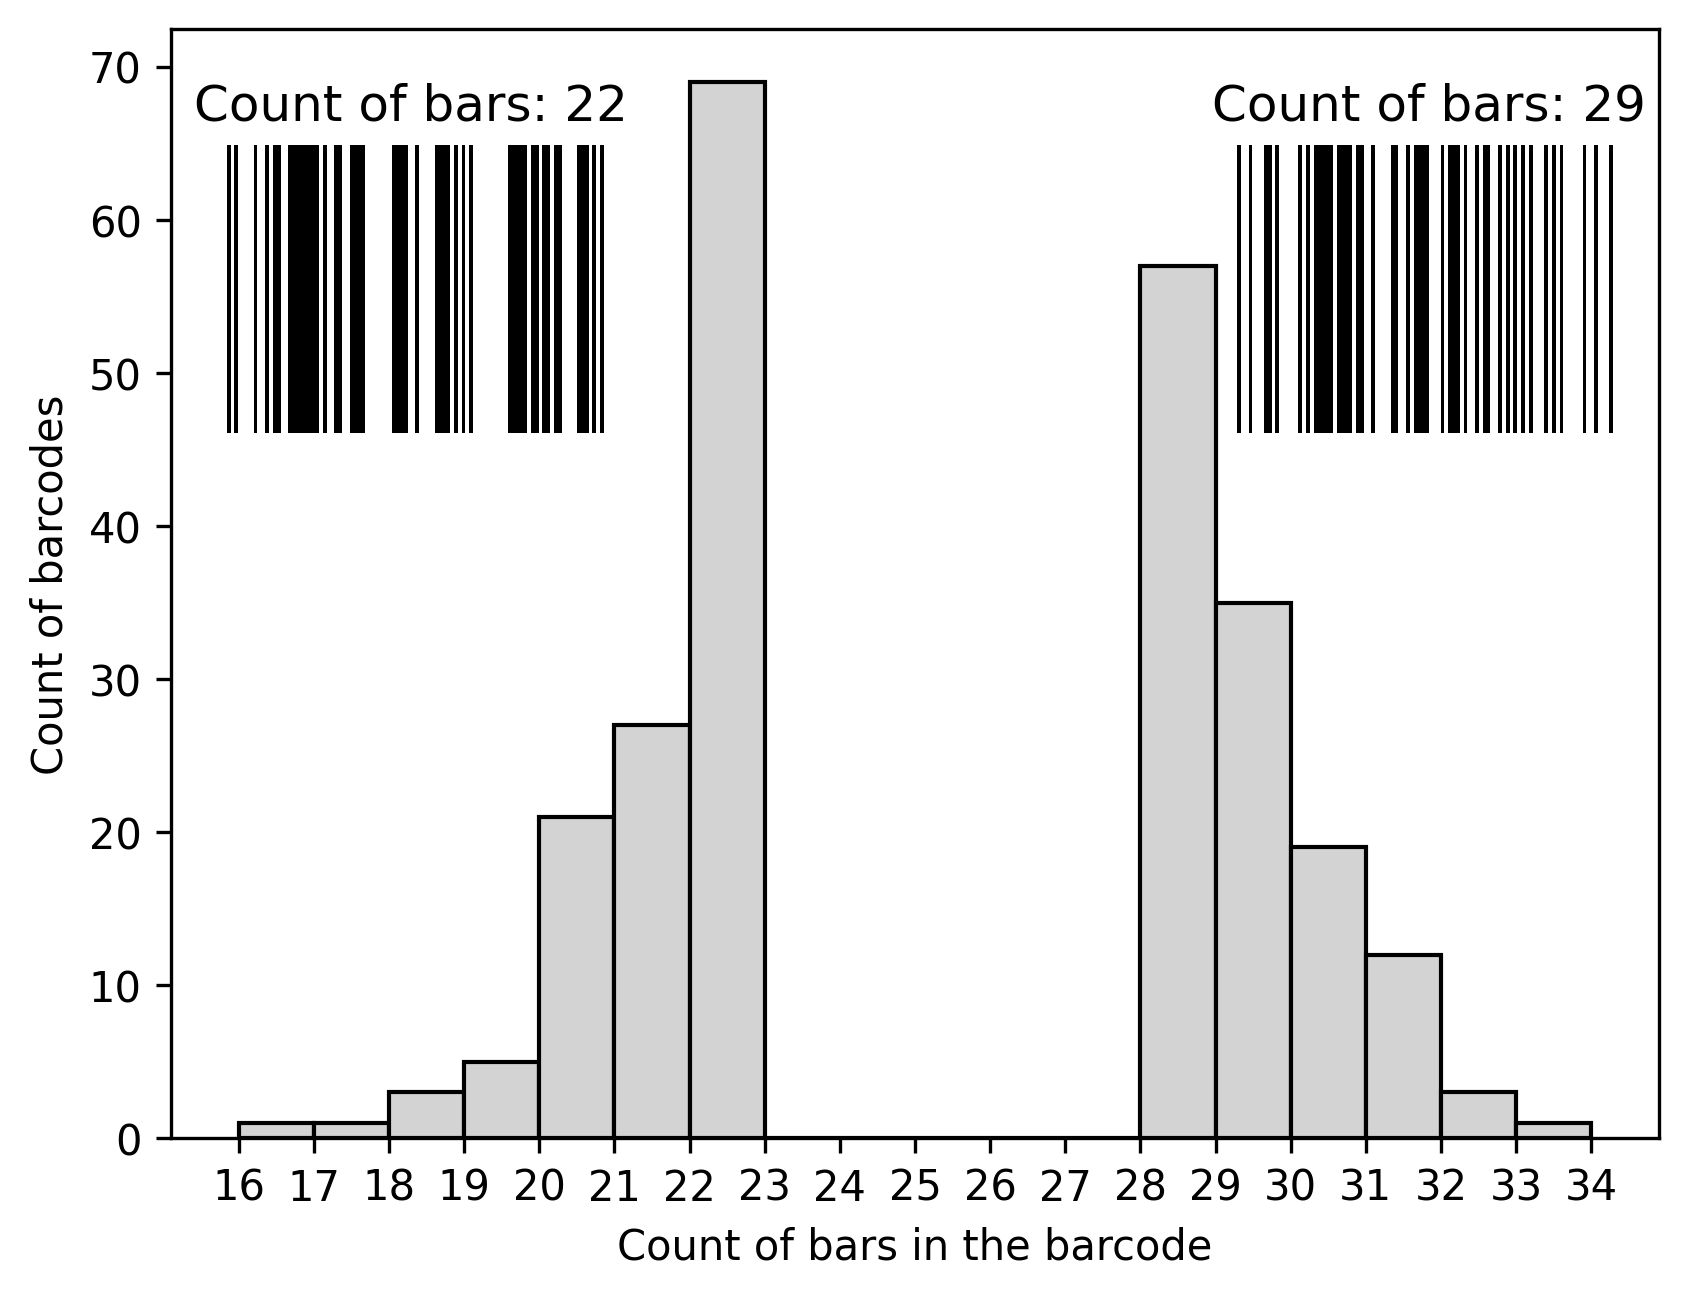

In [ ]:
def plot_barcode_distr(show_categories=False):
    fig, ax = plt.subplots()

    n_bins = max(X) - min(X)
    rng = (min(X), max(X))
    if show_categories:
        heights, bins = np.histogram(X[~y], bins=n_bins, range=rng)
        ax.bar(bins[:-1], heights, fc=COLOR1, ec='black')
        heights, bins = np.histogram(X[y], bins=n_bins, range=rng)
        ax.bar(bins[:-1], heights, fc=COLOR2, ec='black')
        ax.axvline(25, color='purple', linewidth=3)
    else:
        ax.hist(X, bins=n_bins, fc='lightgray', ec='black')

    labels = np.arange(min(X), max(X) + 1)
    ax.set_xticks(ticks=labels, labels=labels)
    ax.set_xlabel('Count of bars in the barcode')
    ax.set_ylabel('Count of barcodes')

    ax_inset = fig.add_axes([0.15, 0.6, 0.2, 0.2])  # [left, bottom, w, h]
    ax_inset.imshow(codes[~y][2].reshape(1, -1), cmap='binary', aspect='auto')
    ax_inset.axis('off')  # Turn off axis for the inset image
    ax_inset.set_title(f'Count of bars: {X[~y][2]}')

    ax_inset = fig.add_axes([0.68, 0.6, 0.2, 0.2])  # [left, bottom, w, h]
    ax_inset.imshow(codes[y][0].reshape(1, -1), cmap='binary', aspect='auto')
    ax_inset.axis('off')  # Turn off axis for the inset image
    ax_inset.set_title(f'Count of bars: {X[y][0]}')


plot_barcode_distr(show_categories=False)

 ## Display categories and decision boundary

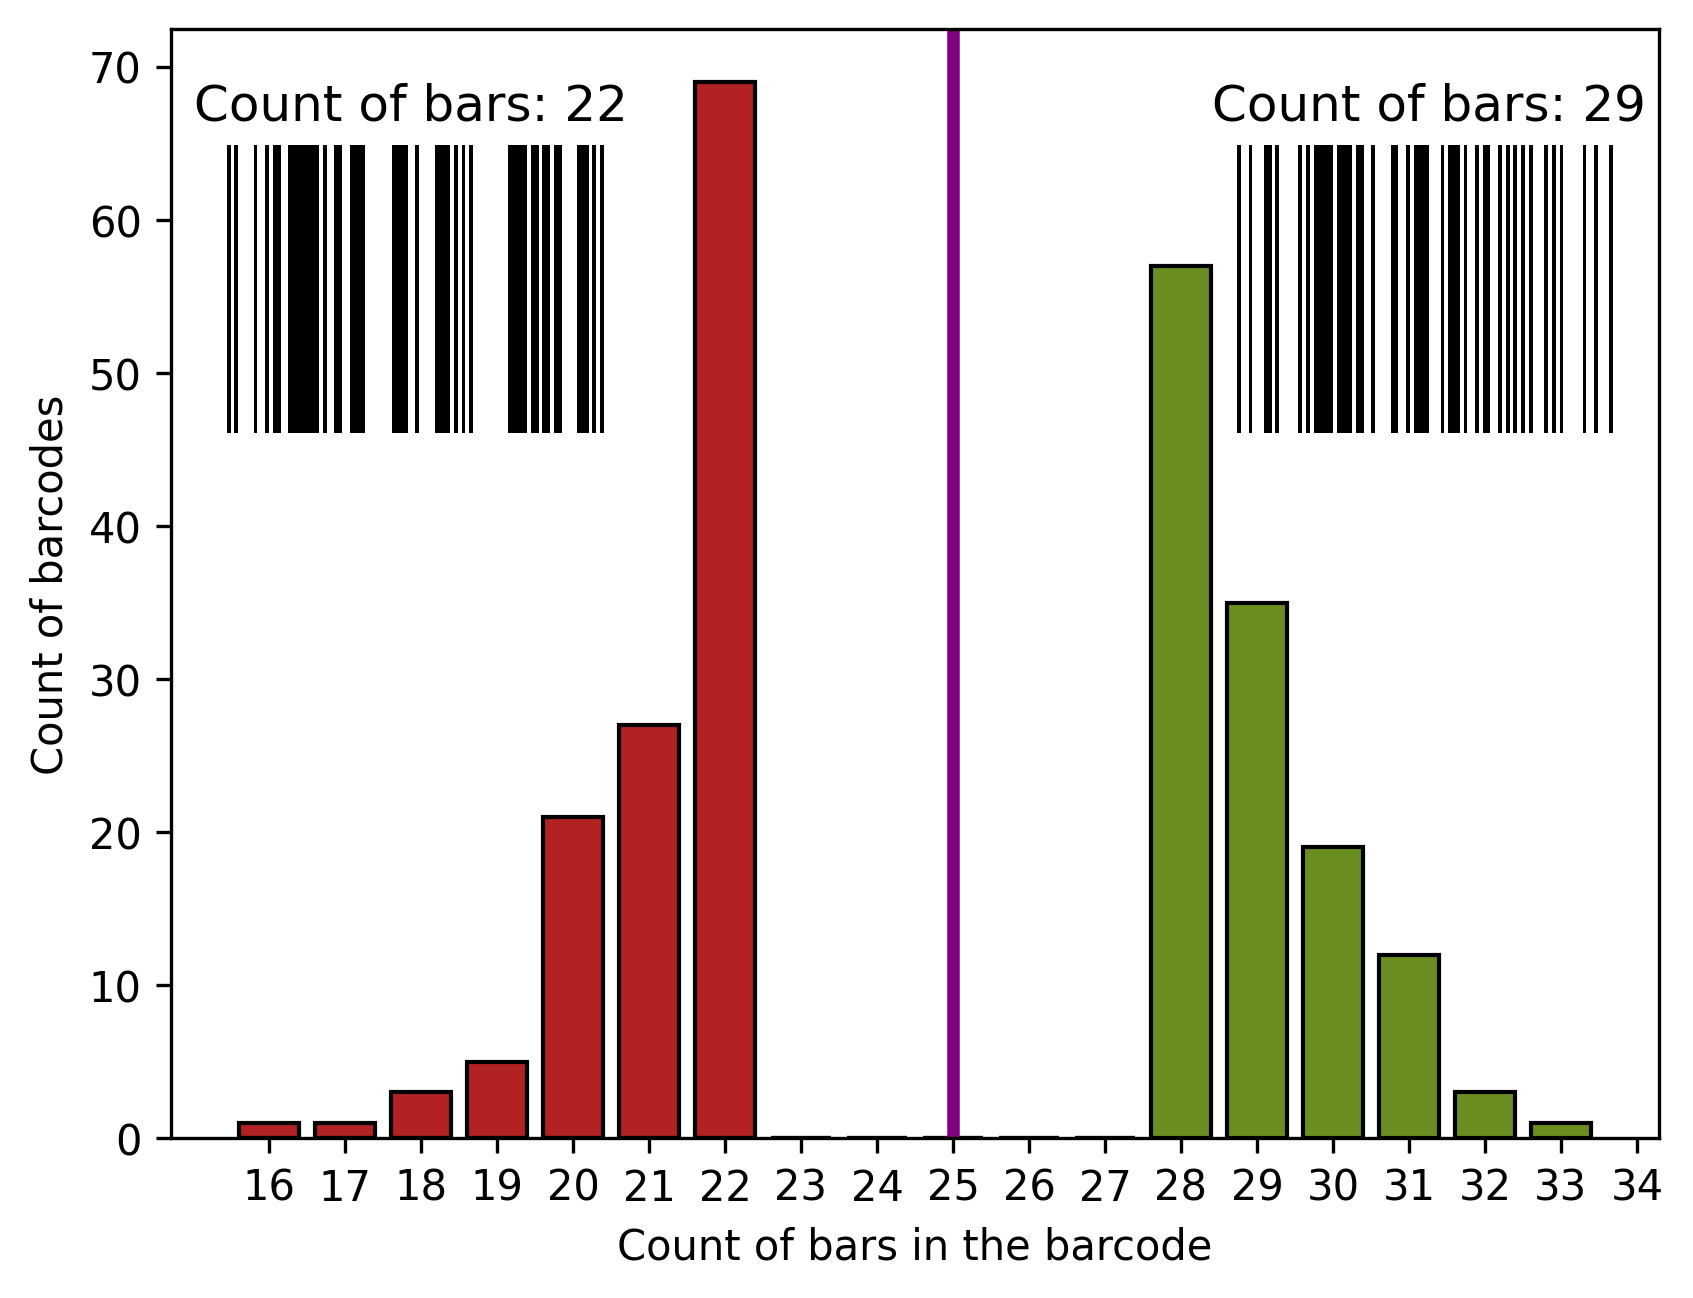

In [ ]:
plot_barcode_distr(show_categories=True)

 ## Learning process

In [ ]:
data = {}
lrs = [.1, .3, 3]
for lr in lrs:
    current_boundary = 30
    y_preds = []
    boundaries = [current_boundary]
    for xi, yi in zip(X, y):
        y_pred = xi > current_boundary
        y_preds.append(y_pred)
        dL = float(y_pred) - yi
        current_boundary += lr * dL * xi
        boundaries.append(current_boundary)
    data[lr] = [y_preds, boundaries]


@interact(step=IntSlider(min=0, max=len(codes) * 4 - 1, value=0),
          lr=SelectionSlider(options=data.keys(), value=.3,
                             description='learning rate'),
          )
def learn_barcode(step, lr):
    """
    Display barcodes
    """
    y_preds, boundaries = data[lr]
    pixel_per_bar = 8
    dpi = 200
    i = step // 4
    code = codes[i]
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(len(code) * pixel_per_bar / dpi * 2.5, 2), dpi=dpi,
        gridspec_kw={'width_ratios': [3, 7]})
    ax1.set_axis_off()

    barcode_cmap = 'binary'
    bar_cmap = COLOR2 if y_preds[i] else COLOR1
    current_boundary = boundaries[i]
    if step % 4 == 0:
        bar_cmap = 'purple'
    elif step % 4 == 1:
        # y_pred = X[i] > current_boundary
        pass
    elif step % 4 == 2:
        barcode_cmap = class2 if y[i] else class1
    else:
        barcode_cmap = class2 if y[i] else class1
        # current_boundary -= lr * (int(y[i]) - int(y_pred))
        current_boundary = boundaries[i + 1]

    ax1.imshow(code.reshape(1, -1), cmap=barcode_cmap, aspect='auto')

    heights, bins = np.histogram(X[:i + 1], bins=int(max(X) - min(X)),
                                 range=(min(X), max(X)))
    ax2.bar(bins[:-1], heights, fc='lightgray', ec='black')
    ax2.bar([X[i]], heights[bins[:-1] == X[i]], fc=bar_cmap, ec='black')
    labels = np.arange(min(X), max(X) + 1)
    ax2.set_xticks(ticks=labels, labels=labels)

    ax2.axvline(current_boundary, color='purple', linewidth=3)

interactive(children=(IntSlider(value=0, description='step', max=1015), SelectionSlider(description='learning …

 # Learning example in two dimensions with noise

In [ ]:
samples = []
rng = np.random.RandomState(seed=0)
cov = .05 * np.ones((2, 2))
cov[0, 0] *= 3
cov[1, 1] *= 3
for yi, mu in enumerate(np.array([(1, .5), (.5, 1)])):
    for _ in range(50):
        size = rng.randint(2, 10)
        s = []
        while True:
            si = rng.multivariate_normal(mu, cov)
            if np.any(si <= .1):
                continue
            s.append(si)
            if len(s) == size:
                break

        xys = rng.uniform(3, 13, size=(len(s), 2))
        samples.append({
            'X': np.array(s),  # width, height
            'y': bool(yi),
            'xy': xys,
        })

        if len(samples) == 50:
            break

inds = np.arange(len(samples))
order = rng.permutation(inds)
samples = [samples[i] for i in order]


def plot_rectangles(Xs, xys, color, ax=None):
    if ax is None:
        ax = plt.subplot(111)

    lims_data = []
    for xy, (width, height) in zip(xys, Xs.tolist()):
        rect = matplotlib.patches.Rectangle(
            xy, width, height, color=color, alpha=.5)
        ax.add_artist(rect)
        lims_data.append([
            xy[0] - width,
            xy[1] - height,
            xy[0] + width,
            xy[1] + height
        ])

    lims_data = np.stack(lims_data)
    lim_min = lims_data[:, :2].min()
    lim_max = lims_data[:, 2:].max()

    ax.set_xlim([lim_min, lim_max])
    ax.set_ylim([lim_min, lim_max])
    ax.set_aspect(1)
    ax.set_axis_off()


@interact(step=IntSlider(min=0, max=len(samples) * 2 - 1, value=0))
def _plot_rectangles(step):
    i = step // 2

    if step % 2 == 0:
        color = 'lightgray'
    else:
        color = COLOR2 if samples[i]['y'] else COLOR1

    plot_rectangles(samples[i]['X'], samples[i]['xy'], color)

interactive(children=(IntSlider(value=0, description='step', max=199), Output()), _dom_classes=('widget-intera…

 ## Plot distribution

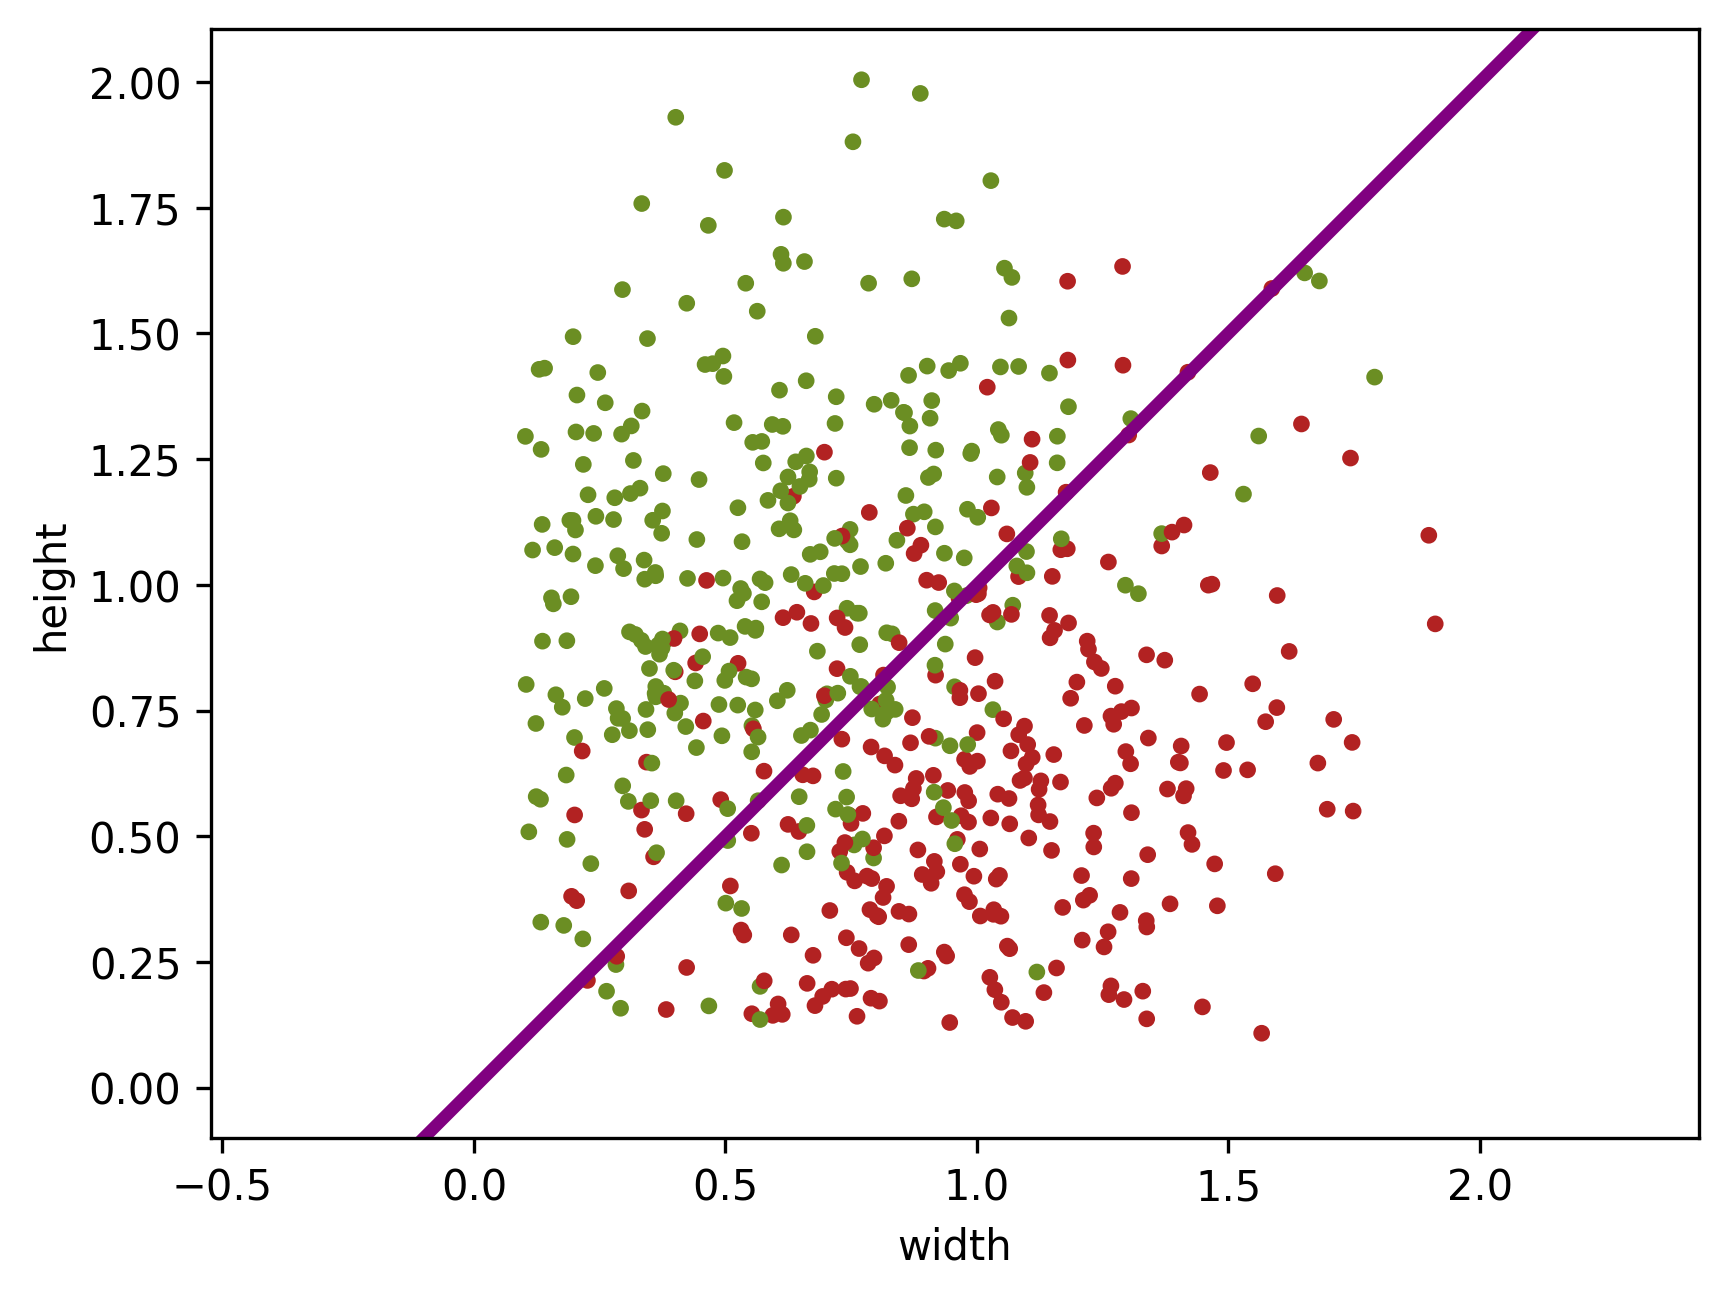

In [ ]:
ax = plt.subplot(111)
X = np.concatenate([s['X'] for s in samples])
y = np.concatenate([[s['y']] * len(s['X']) for s in samples])
colors = [COLOR2 if yi else COLOR1 for yi in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, marker='.')
ax.axline([0, 0], slope=1, color='purple', linewidth=3)

ax.set_xlabel('width')
ax.set_ylabel('height')
_ = ax.axis('equal')

 ## Learning procedure

In [ ]:
data = {}
lrs = [.1, 1, 2]
rng = np.random.RandomState(0)
for lr in lrs:
    for with_x in [True, False]:
        W = rng.random(size=2)
        # make sure the decision boundary is in the first quadrant
        W[0] = -W[0]
        y_preds = []
        Ws = [W.copy()]
        for sample in samples:
            xi = sample['X']
            y_pred = xi @ W > 0
            y_preds.append(y_pred)

            dL = np.mean(y_pred.astype(float) - float(sample['y']))
            if with_x:
                dLdW = xi * dL
            else:
                dLdW = dL * np.ones_like(xi)
            W -= lr * np.mean(dLdW, axis=0)
            Ws.append(W.copy())
        data[(lr, with_x)] = [y_preds, Ws]


@interact(step=IntSlider(min=0, max=len(samples) * 4 - 1, value=0),
          lr=SelectionSlider(options=set([k[0] for k in data]), value=1,
                             description='learning rate'),
          with_x=Checkbox(value=True,
                          description='Use datapoints for updates?'
                          )
          )
def learn_rectangles(step, lr, with_x=True):
    i = step // 4
    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        figsize=(10, 5)
    )
    ax1.set_axis_off()

    y_preds, Ws = data[(lr, with_x)]
    y_pred = y_preds[i]
    W = Ws[i]
    x = samples[i]['X']
    y = samples[i]['y']

    sample_color = 'lightgray'
    new_dot_color = [COLOR2 if yi else COLOR1 for yi in y_pred]
    if step % 4 == 0:
        new_dot_color = 'purple'
    elif step % 4 == 1:
        pass
    elif step % 4 == 2:
        sample_color = COLOR2 if y else COLOR1
    else:
        sample_color = COLOR2 if y else COLOR1
        W = Ws[i + 1]

    plot_rectangles(x, samples[i]['xy'], sample_color, ax=ax1)

    if i > 0:
        Xcat = np.concatenate([s['X'] for s in samples[:i]])
        ax2.scatter(Xcat[:, 0], Xcat[:, 1], c=colors[:len(Xcat)], marker='.',
                    alpha=.5)
    ax2.scatter(x[:, 0], x[:, 1], fc=new_dot_color, marker='o')

    if W[1] == 0:
        ax2.axvline(0, color='purple', linewidth=3)
    else:
        slope = -W[0] / W[1]
        ax2.axline([0, 0], slope=slope, color='purple', linewidth=3)

    ax2.set_xlim([0, X.max()])
    ax2.set_ylim([0, X.max()])
    ax2.set_xlabel('width')
    ax2.set_ylabel('height')

interactive(children=(IntSlider(value=0, description='step', max=399), SelectionSlider(description='learning r…

 ## Decision boundary is a linear combo of width and height

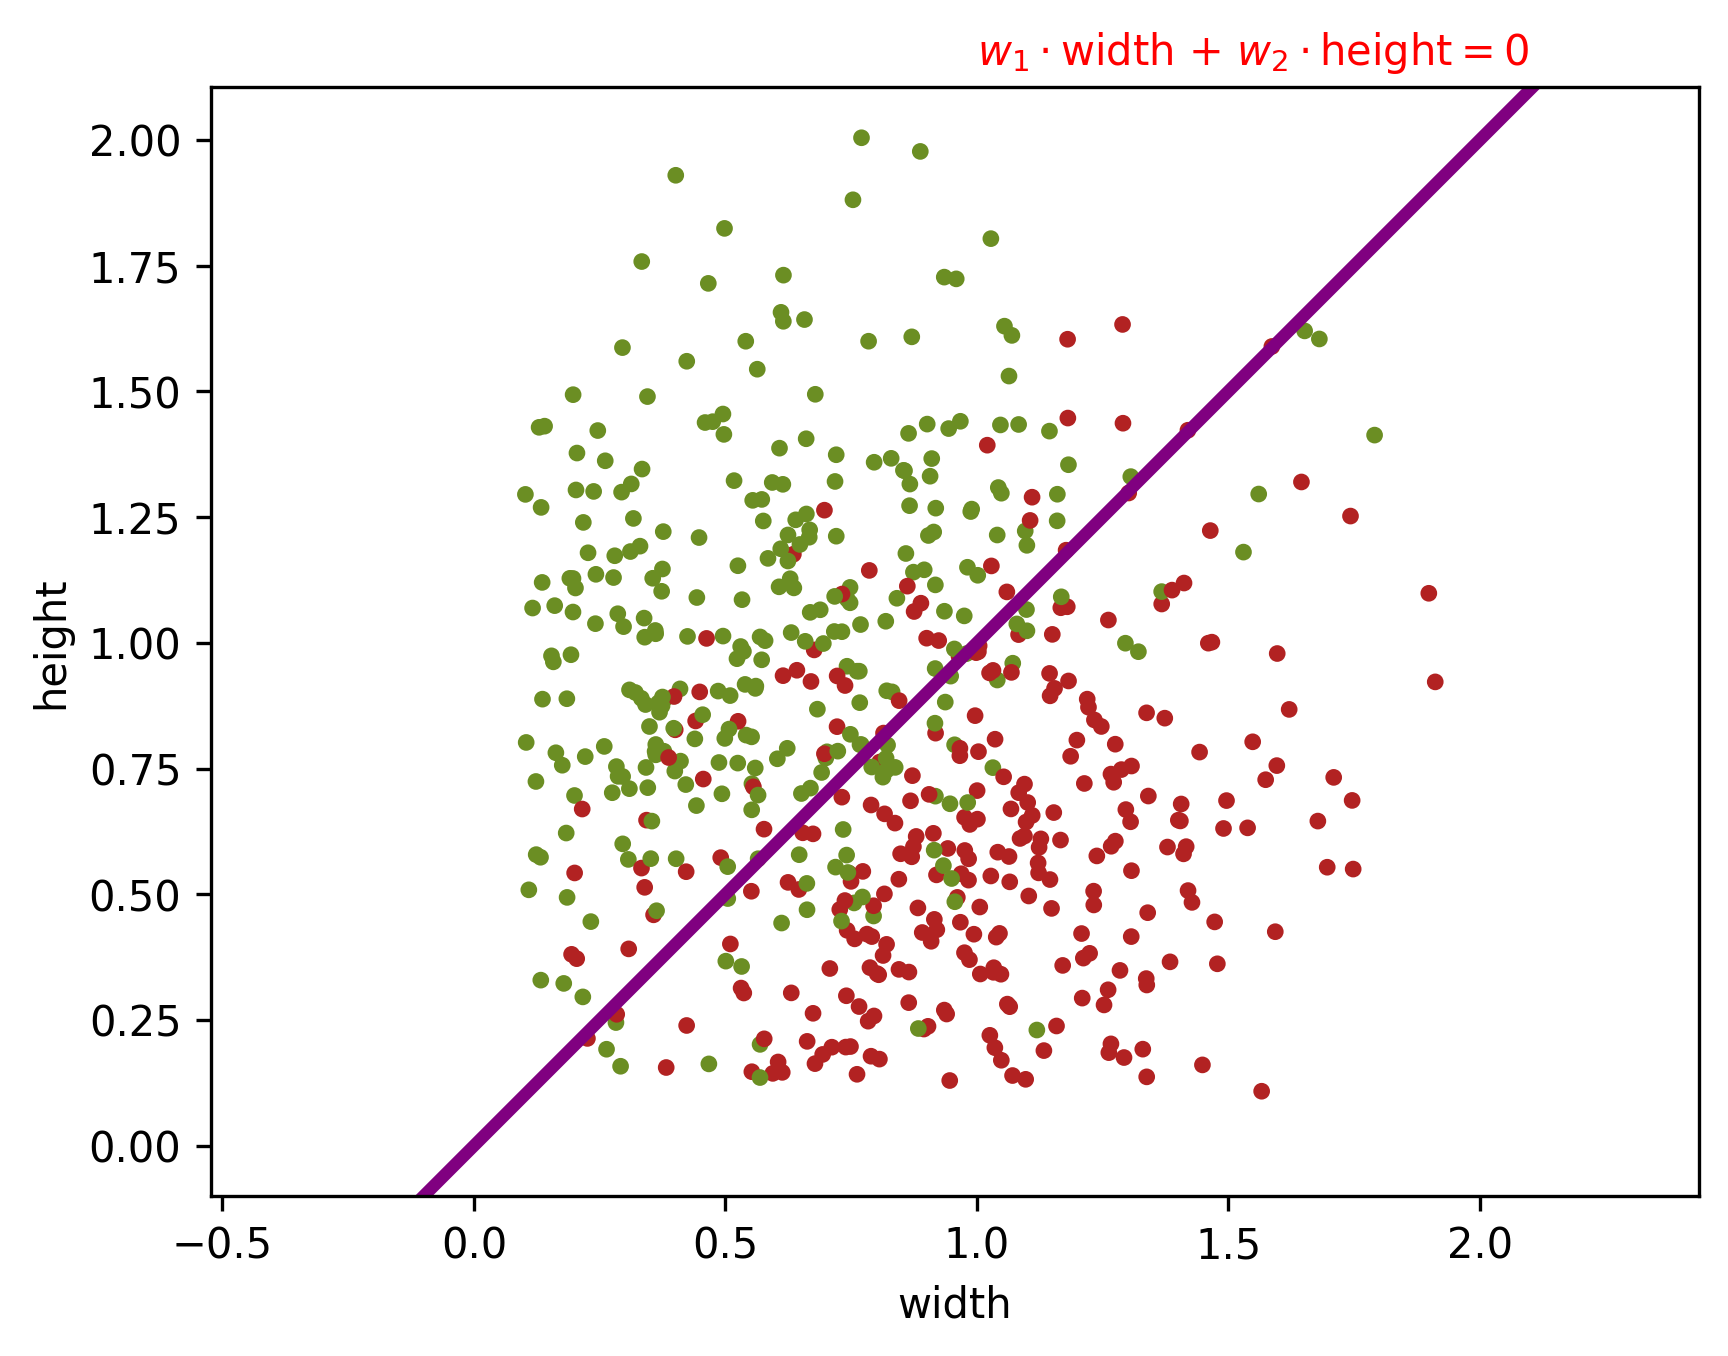

In [ ]:
ax = plt.subplot(111)
X = np.concatenate([s['X'] for s in samples])
y = np.concatenate([[s['y']] * len(s['X']) for s in samples])
colors = [COLOR2 if yi else COLOR1 for yi in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, marker='.')
ax.axline([0, 0], slope=1, color='purple', linewidth=3)
ax.text(1, 2.15, r'$w_1 \cdot$width + $w_2 \cdot$height$= 0$', color='red')

ax.set_xlabel('width')
ax.set_ylabel('height')
_ = ax.axis('equal')

 ## Draw as a network

Text(0.5, 0.2, '$w_2$')

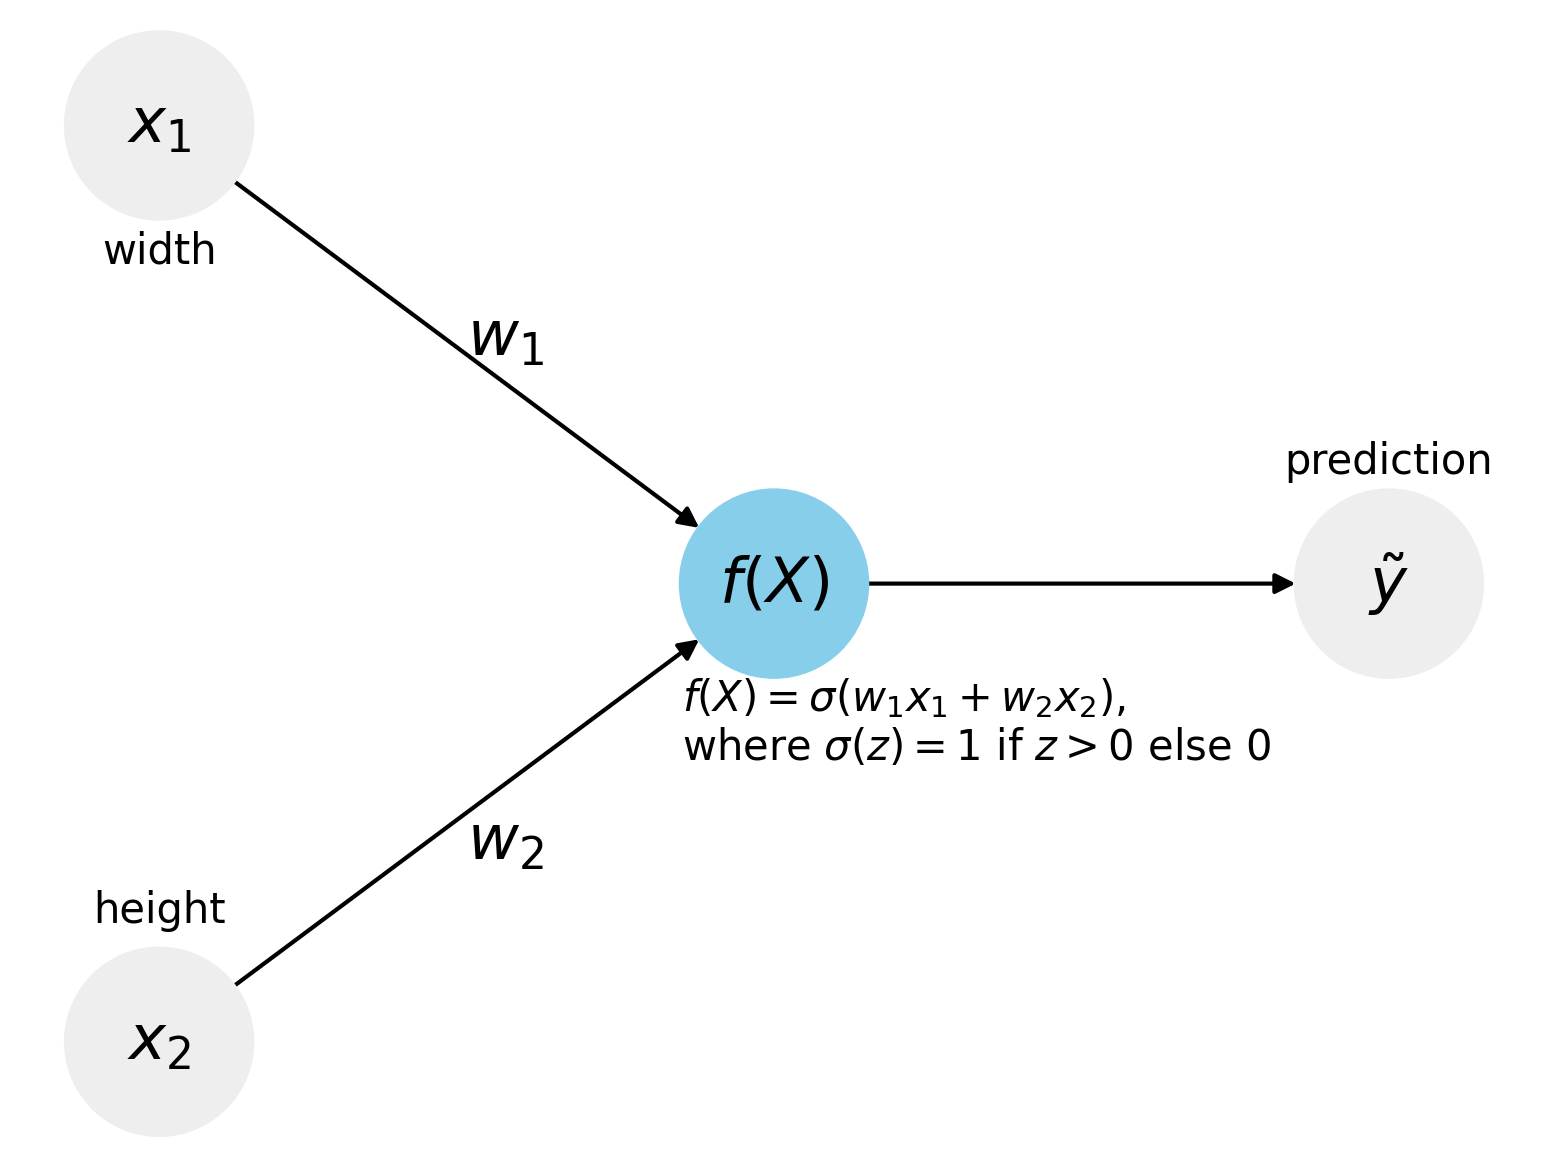

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['x1', 'x2', 'f(X)', 'y'])
G.add_edges_from([('x1', 'f(X)'), ('x2', 'f(X)'), ('f(X)', 'y')])

labels = {'x1': '$x_1$', 'x2': '$x_2$', 'f(X)': '$f(X)$', 'y': r'$\tilde{y}$'}
pos = {'x1': (0, 1), 'x2': (0, 0), 'f(X)': (1, .5), 'y': (2, .5)}
node_colors = ['skyblue' if n.startswith('f') else '#eee' for n in G.nodes()]
ax = plt.subplot(111)
nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
        node_color=node_colors, font_size=15, arrows=True, ax=ax)

ax.text(0, .85, 'width', ha='center')
ax.text(0, .13, 'height', ha='center')
ax.text(2, .62, 'prediction', ha='center')

ax.text(.85, .4, (r'$f(X) = \sigma(w_1 x_1 + w_2 x_2)$,' + '\n'
                  + r'where $\sigma(z) = 1$ if $z > 0$ else $0$'),
        va='top')

ax.text(.5, .75, '$w_1$', fontsize=15)
ax.text(.5, .2, '$w_2$', fontsize=15)

 ## Backpropagation

In [ ]:
X = np.array([
    [.5, 1],
    [1.5, 1.7],
    [1, .7],
    [2, .5]
])
y = np.array([True, True, False, False])

data = []
w1 = -4
w2 = 1
lr = 1
for (x1, x2), yi in zip(X, y):
    n1 = w1 * x1 + w2 * x2
    y_pred = n1 > 0
    dL = float(y_pred) - yi
    data.append([x1, x2, w1, w2, n1, yi, y_pred, dL])
    w1 -= lr * x1 * dL
    w2 -= lr * x2 * dL


@interact(step=IntSlider(min=0, max=len(data) * 6 - 1, value=0))
def _plot_perceptron(step):
    i = step // 6

    x1, x2, w1, w2, n1, y, y_pred, dL = data[i]

    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        figsize=(10, 5)
    )
    plt.tight_layout(pad=5)
    # ax2.set_axis_off()

    j = step % 6
    if j == 0:
        labels = {}
    elif j == 1:
        labels = {
            'x1': str(x1),
            'x2': str(x2),
        }
    elif j == 2:
        labels = {
            'x1': str(x1),
            'x2': str(x2),
            'f(X)': f'{n1:g}',
        }
    elif j >= 3:
        labels = {
            'x1': str(x1),
            'x2': str(x2),
            'f(X)': f'{n1:g}',
            'y': str(y_pred)
        }
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
            node_color=node_colors, font_size=15, arrows=True, ax=ax1)

    ax1.text(0, .85, 'width', ha='center')
    ax1.text(0, .15, 'height', ha='center')

    if j <= 4:
        ax1.text(.5, .75, str(w1), fontsize=15)
        ax1.text(.5, .2, str(w2), fontsize=15)

    if j > 1:
        ax1.text(.85, .62, rf'${x1} \cdot {w1} + {x2} \cdot {w2}$')
    if j > 2:
        ax1.text(1.5, .55, f'${n1:g} > 0?$', ha='center')

    if j > 3:
        ax1.text(1.95, .6,
                 f'error$= {int(y_pred)} - {int(y)} = {int(dL)}$',
                 color='red')
    if j > 4:
        ax1.text(.8, .85,
                 rf'update = ${int(dL)} \cdot {x1} = {dL * x1}$', color='red')
        ax1.text(.8, .13,
                 rf'update = ${int(dL)} \cdot {x2} = {dL * x2}$', color='red')

        ax1.annotate(str(w1),
                     xy=(2, .55), xycoords='data',
                     xytext=(.5, .75), textcoords='data',
                     fontsize=15,
                     arrowprops=dict(arrowstyle="<-",
                                     connectionstyle="arc3,rad=-0.3",
                                     color='red'),
                     )

        ax1.annotate(str(w2),
                     xy=(2, .45), xycoords='data',
                     xytext=(.5, .2), textcoords='data',
                     fontsize=15,
                     arrowprops=dict(arrowstyle="<-",
                                     connectionstyle="arc3,rad=0.3",
                                     color='red'),
                     )

    t = i + 1 if j > 0 else i
    for entry in data[:t]:
        x1 = entry[0]
        x2 = entry[1]
        y = entry[5]
        rect = matplotlib.patches.Rectangle(
            (.95 * x1, .95 * x2), x1 / 10, x2 / 10,
            color=COLOR2 if y else COLOR1, alpha=.5)
        ax2.add_artist(rect)

    ax2.axline([0, 0], slope=-w1 / w2, color='purple', linewidth=3)

    ax2.set_xlim([0, 3])
    ax2.set_ylim([0, 3])
    ax2.set_aspect(1)

interactive(children=(IntSlider(value=0, description='step', max=23), Output()), _dom_classes=('widget-interac…

 # XOR example

In [ ]:
samples = []
rng = np.random.RandomState(seed=0)
for i, mu in enumerate(itertools.product([.5, 1], repeat=2)):
    for _ in range(50):
        size = rng.randint(2, 10)
        s = []
        while True:
            si = rng.normal(mu, .05)
            if np.any(si <= .1):
                continue
            s.append(si)
            if len(s) == size:
                break

        xys = rng.uniform(3, 13, size=(len(s), 2))
        samples.append({
            'X': np.array(s),  # width, height
            'y': i in [1, 2],
            'xy': xys,
        })

        if len(samples) == 50:
            break

inds = np.arange(len(samples))
order = rng.permutation(inds)
samples = [samples[i] for i in order]


interact(_plot_rectangles,
         step=IntSlider(min=0, max=len(samples) * 2 - 1, value=0))

interactive(children=(IntSlider(value=0, description='step', max=399), Output()), _dom_classes=('widget-intera…

<function __main__._plot_rectangles(step)>

 ## Plot distribution
 Issue: not separable by a single line!

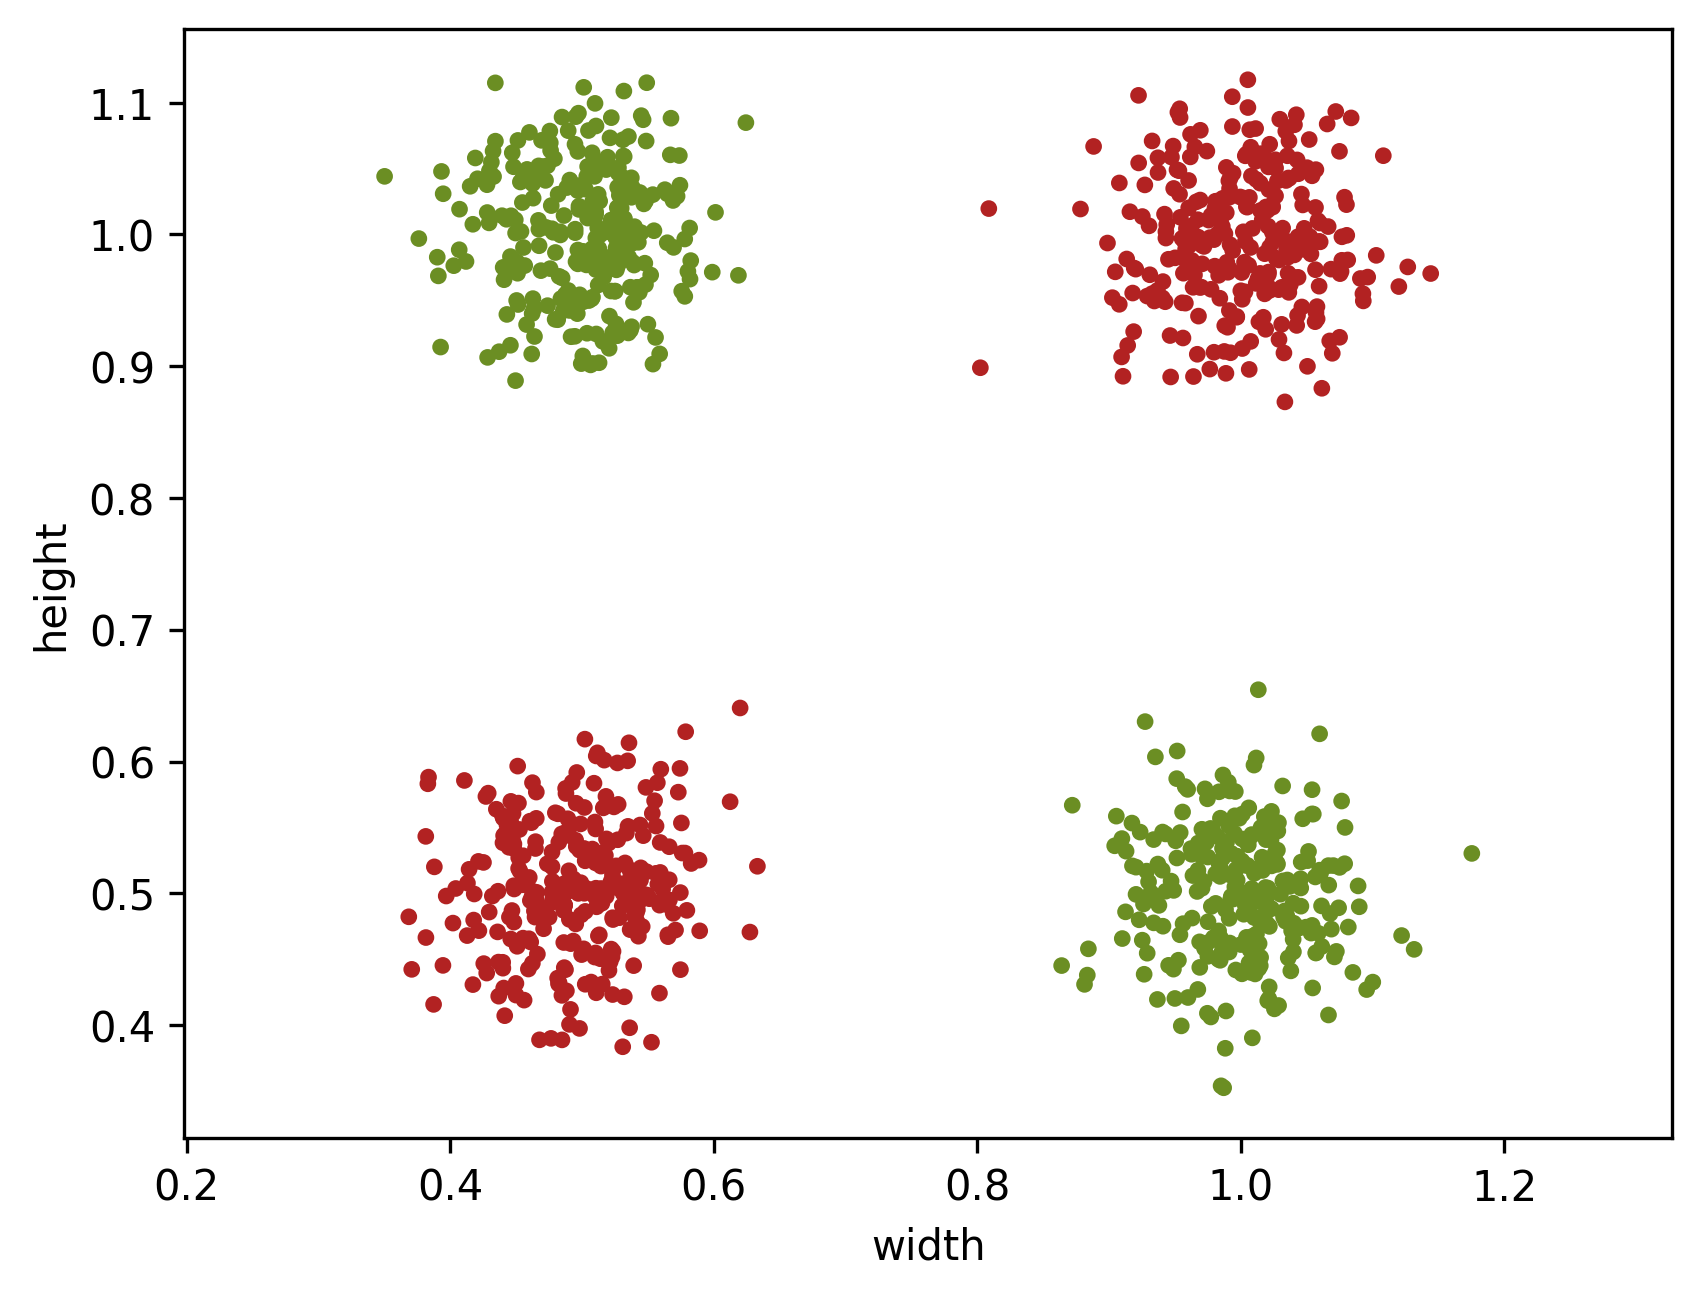

In [ ]:
ax = plt.subplot(111)
X = np.concatenate([s['X'] for s in samples])
y = np.concatenate([[s['y']] * len(s['X']) for s in samples])
colors = [COLOR2 if yi else COLOR1 for yi in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, marker='.')

ax.set_xlabel('width')
ax.set_ylabel('height')
_ = ax.axis('equal')

 ## Does computing aspect ratio work?

Text(0, 0.5, 'Count of rectangles')

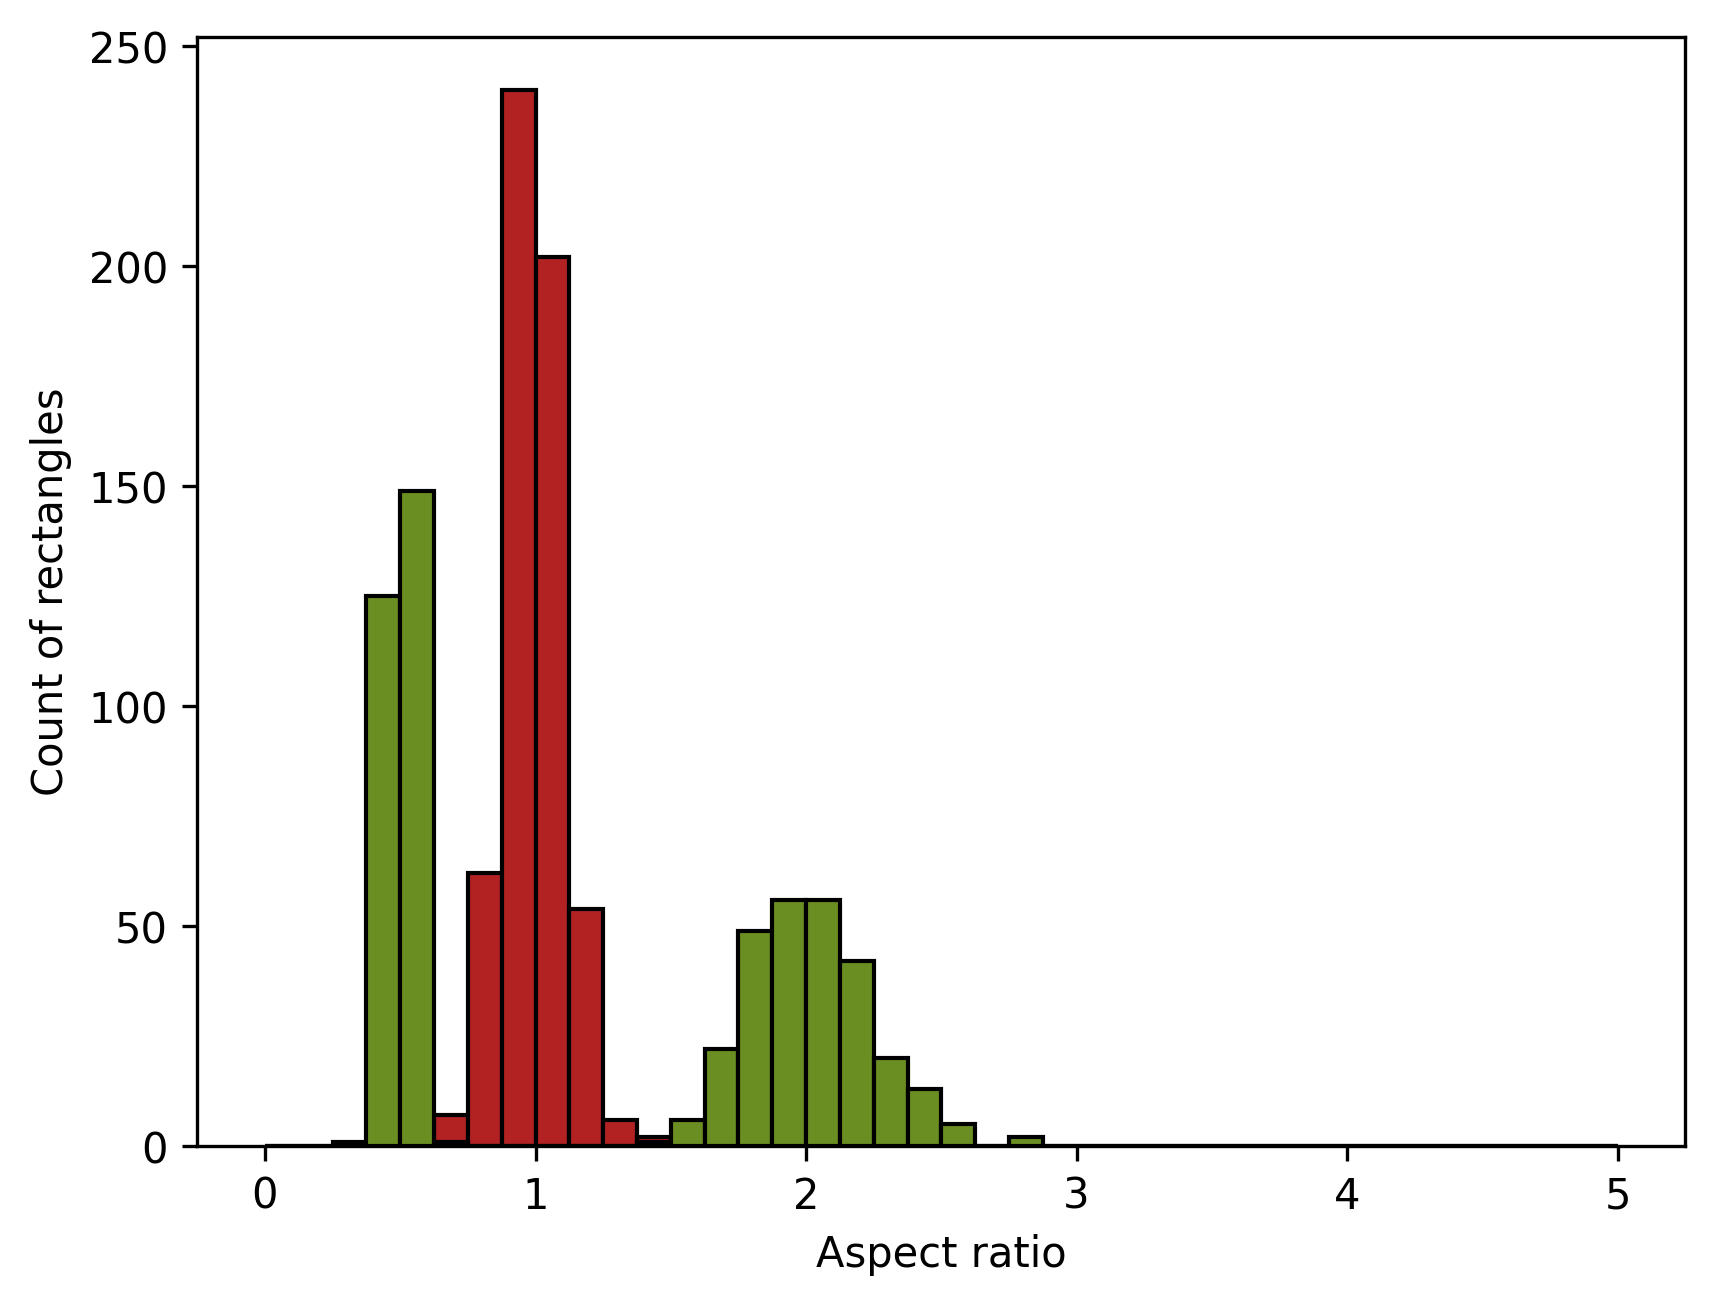

In [ ]:
ax = plt.subplot(111)
aspect_ratio = np.concatenate([s['X'][:, 0] / s['X'][:, 1] for s in samples])
y = np.concatenate([[s['y']] * len(s['X']) for s in samples])

ax.hist(aspect_ratio[~y], fc=COLOR1, ec='black', bins=40, range=(0, 5))
ax.hist(aspect_ratio[y], fc=COLOR2, ec='black', bins=40, range=(0, 5))

ax.set_xlabel('Aspect ratio')
ax.set_ylabel('Count of rectangles')

 ## Need a two-step strategy

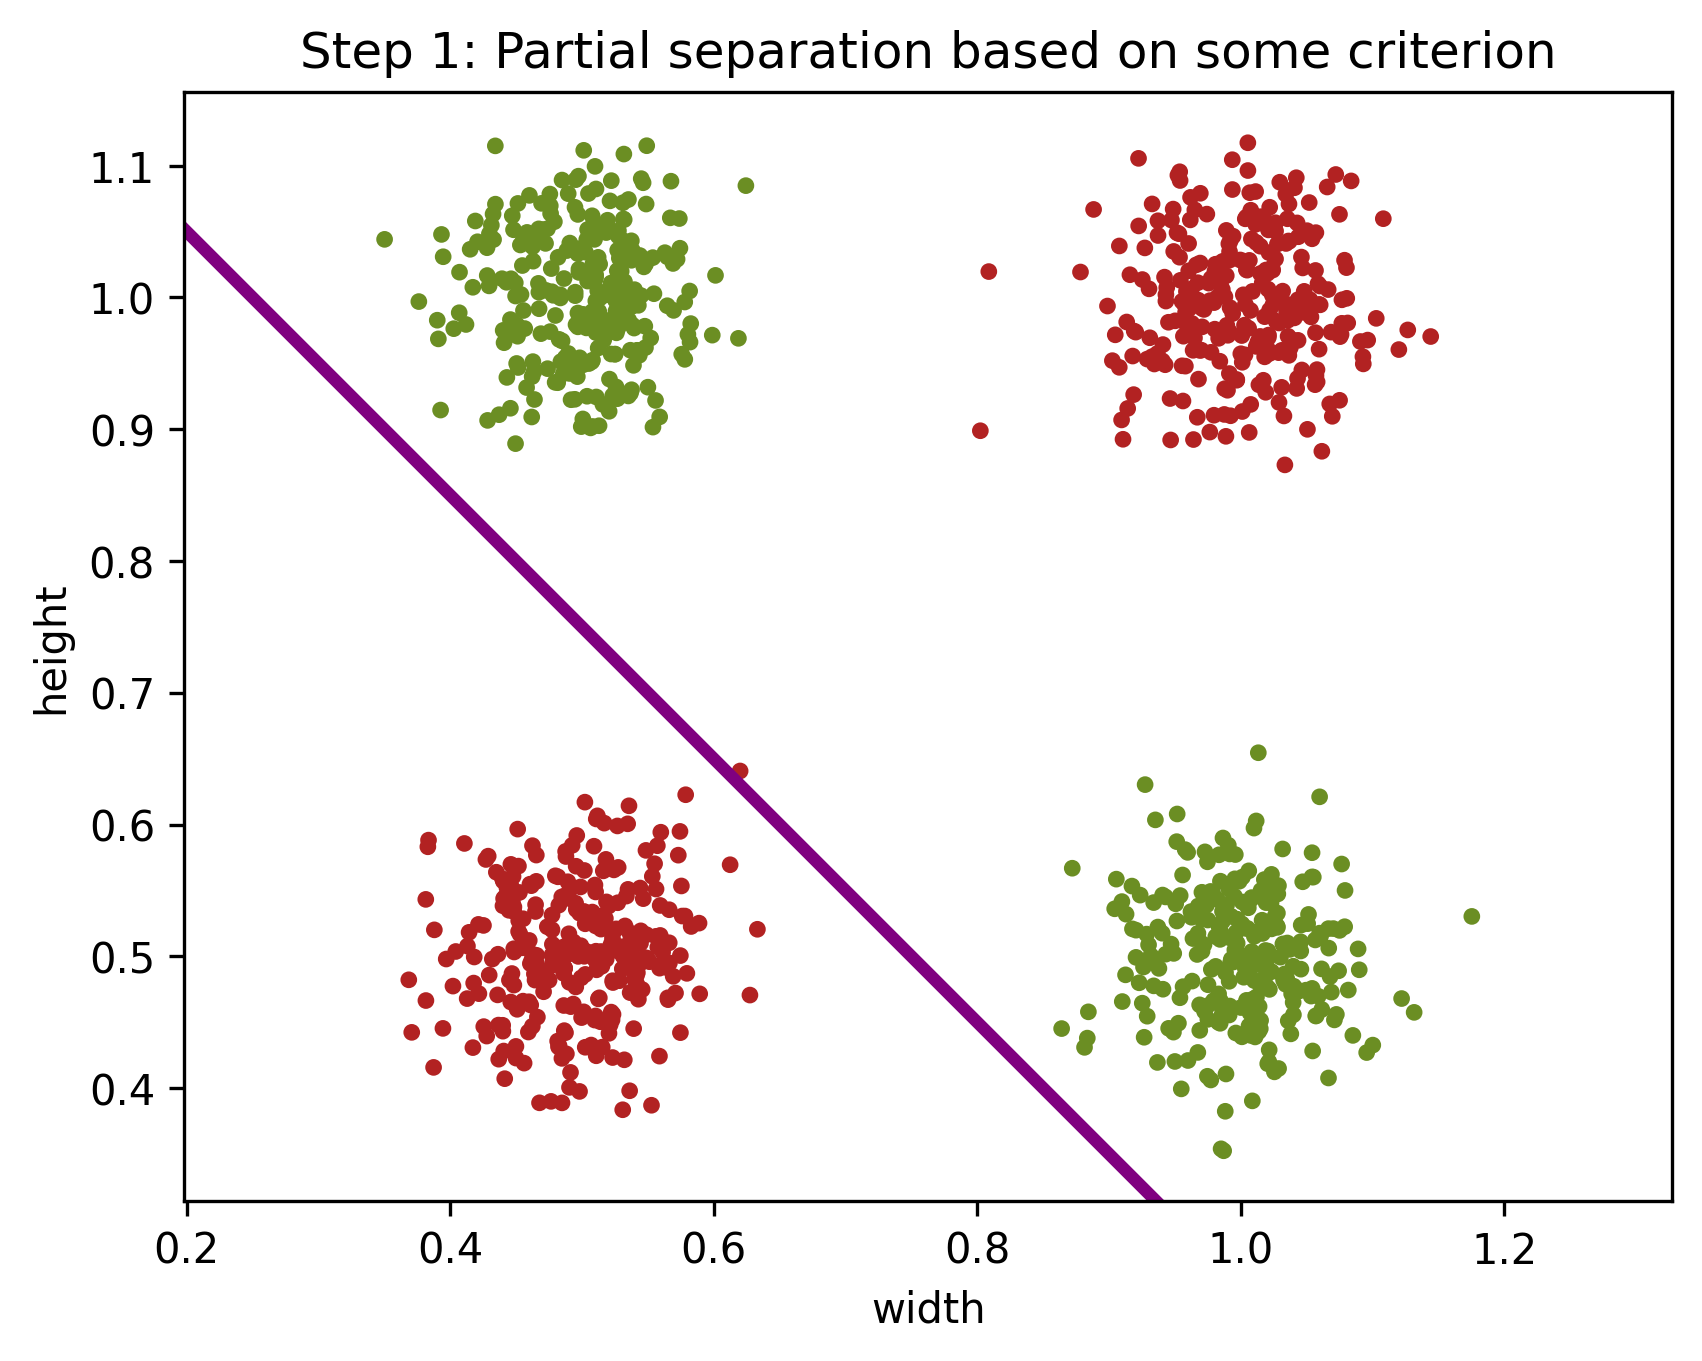

In [ ]:
ax = plt.subplot(111)
X = np.concatenate([s['X'] for s in samples])
y = np.concatenate([[s['y']] * len(s['X']) for s in samples])
colors = [COLOR2 if yi else COLOR1 for yi in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, marker='.')
ax.axline([0.4, .85], slope=-1, color='purple', lw=3)

ax.set_title('Step 1: Partial separation based on some criterion')
ax.set_xlabel('width')
ax.set_ylabel('height')
_ = ax.axis('equal')

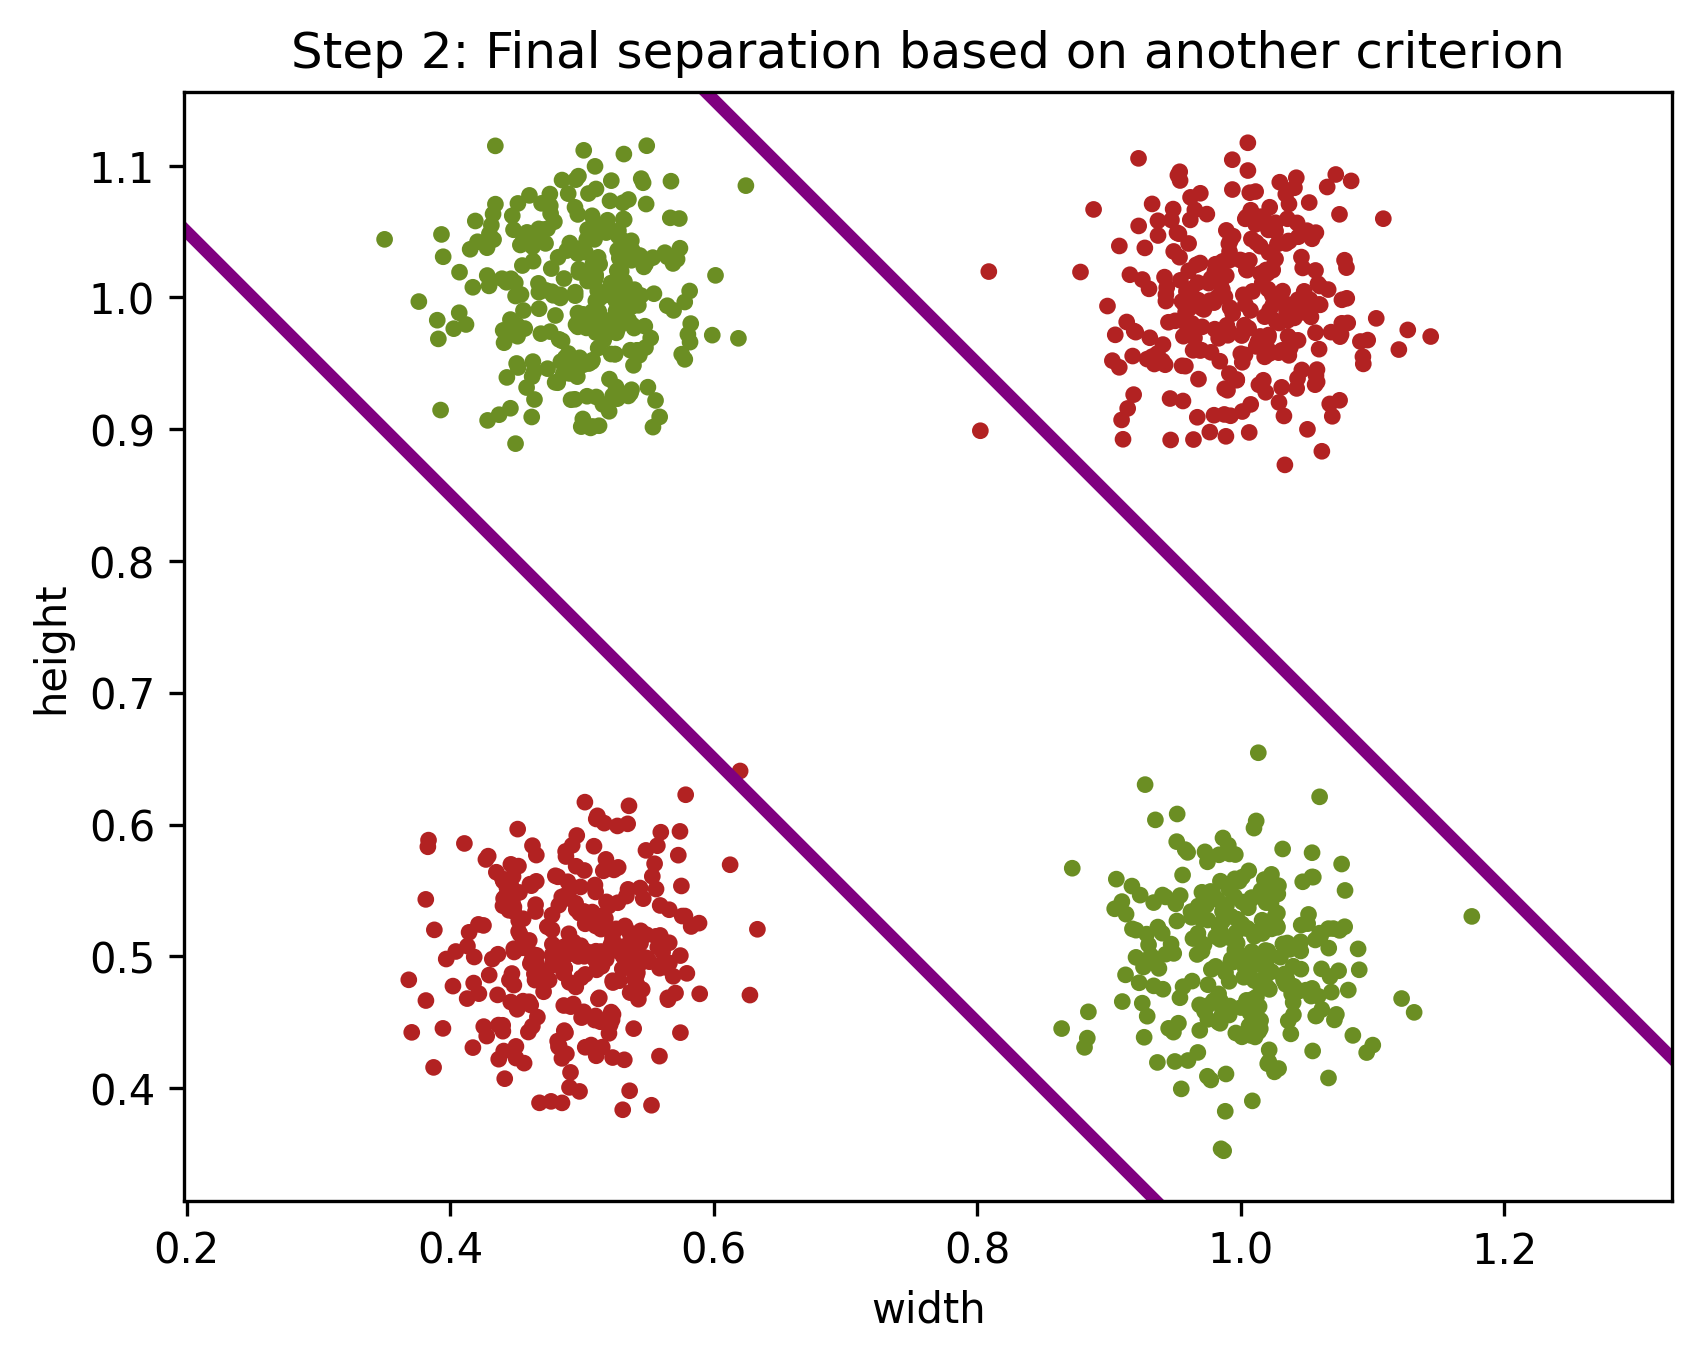

In [ ]:
# %%

ax = plt.subplot(111)
X = np.concatenate([s['X'] for s in samples])
y = np.concatenate([[s['y']] * len(s['X']) for s in samples])
colors = [COLOR2 if yi else COLOR1 for yi in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, marker='.')
ax.axline([0.4, .85], slope=-1, color='purple', lw=3)
ax.axline([0.8, .95], slope=-1, color='purple', lw=3)

ax.set_title('Step 2: Final separation based on another criterion')
ax.set_xlabel('width')
ax.set_ylabel('height')
_ = ax.axis('equal')

 ## Draw as a network

Text(1.5, 0.2, '$w^1_{21}$')

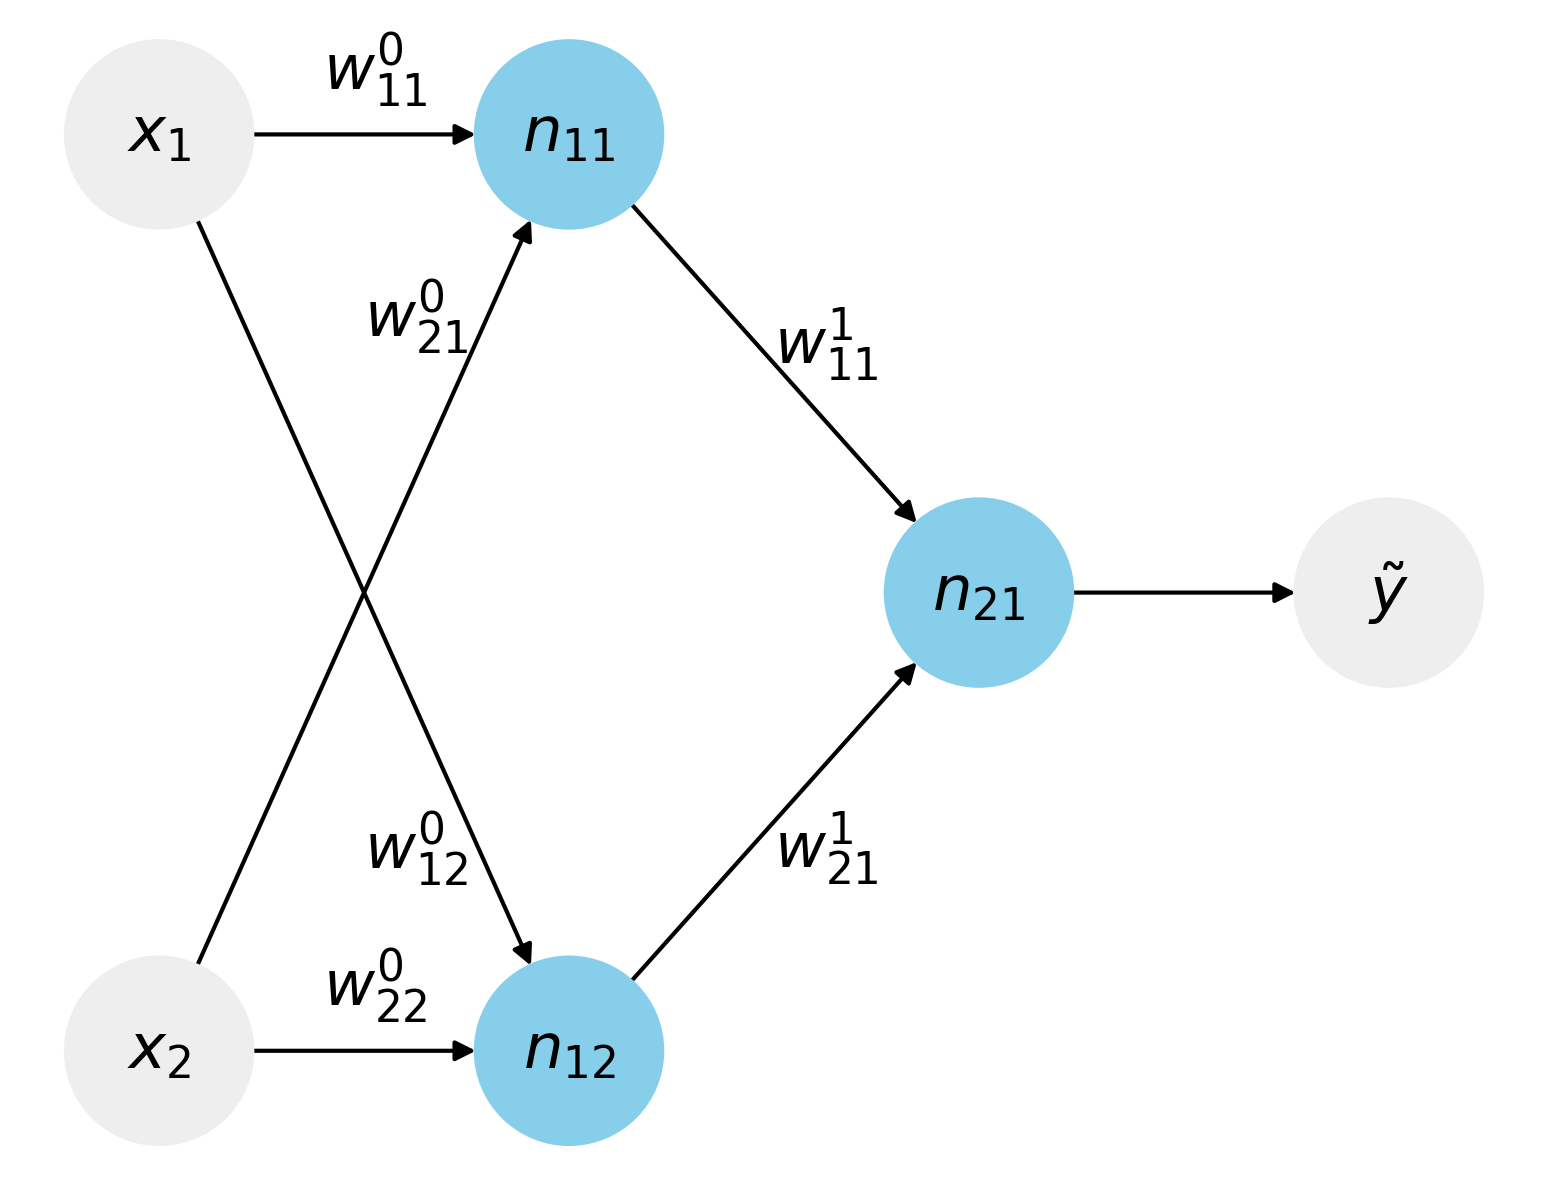

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['x1', 'x2', 'n11', 'n12', 'n21', 'y'])
G.add_edges_from([('x1', 'n11'), ('x1', 'n12'), ('x2', 'n11'), ('x2', 'n12'),
                  ('n11', 'n21'), ('n12', 'n21'), ('n21', 'y')])

labels = {n: f'${n[0]}_' + '{' + str(n[1:]) + '}$'
          for n in G.nodes() if n != 'y'}
labels['y'] = r'$\tilde{y}$'
pos = {
    'x1': (0, 1), 'x2': (0, 0),
    'n11': (1, 1), 'n12': (1, 0),
    'n21': (2, .5),
    'y': (3, .5)
}
node_colors = ['skyblue' if n.startswith('n') else '#eee' for n in G.nodes()]
ax = plt.subplot(111)
nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
        node_color=node_colors, font_size=15, arrows=True, ax=ax)

ax.text(.4, 1.05, '$w^0_{11}$', fontsize=15)
ax.text(.5, .2, '$w^0_{12}$', fontsize=15)
ax.text(.5, .78, '$w^0_{21}$', fontsize=15)
ax.text(.4, .05, '$w^0_{22}$', fontsize=15)
ax.text(1.5, .75, '$w^1_{11}$', fontsize=15)
ax.text(1.5, .2, '$w^1_{21}$', fontsize=15)

 Learning procedure

In [ ]:
class MLP:

    def __init__(self):
        # Intializing close to the correct solution
        # in order to show convergence
        self.w1 = np.array([[6., 3], [6, 3]])
        self.w2 = np.array([[7.], [-7]])
        self.b1 = np.array([[-7., -6]])
        self.b2 = np.array([[-3.]])

    def fit(self, X, y):
        n1 = sigmoid(X @ self.w1 + self.b1)
        n2 = sigmoid(n1 @ self.w2 + self.b2)

        dL = n2 - y

        delta2 = dL * n2 * (1 - n2)
        dLdw2 = n1.T @ delta2
        self.w2 -= lr * dLdw2
        dLdb2 = np.sum(delta2, axis=0, keepdims=True)
        self.b2 -= lr * dLdb2

        delta1 = dL @ self.w2.T * n1 * (1 - n1)
        dLdw1 = X.T @ delta1
        self.w1 -= lr * dLdw1
        dLdb1 = np.sum(delta1, axis=0, keepdims=True)
        self.b1 -= lr * dLdb1

        return n2

    def predict(self, X):
        n1 = sigmoid(X @ self.w1 + self.b1)
        n2 = sigmoid(n1 @ self.w2 + self.b2)
        return n2 > .5

    def weights(self):
        return [self.w1.copy(), self.b1.copy(), self.w2.copy(), self.b2.copy()]


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


samples = []
rng = np.random.RandomState(seed=0)
for i, mu in enumerate(itertools.product([.5, 1], repeat=2)):
    for _ in range(50):
        size = rng.randint(2, 10)
        s = []
        while True:
            si = rng.normal(mu, .1)
            if np.any(si <= .1):
                continue
            s.append(si)
            if len(s) == size:
                break

        xys = rng.uniform(3, 13, size=(len(s), 2))
        samples.append({
            'X': np.array(s),  # width, height
            'y': i in [1, 2],
            'xy': xys,
        })

        if len(samples) == 50000:
            break

inds = np.arange(len(samples))
order = rng.permutation(inds)
samples = [samples[i] for i in order]


lims = [0, np.concatenate([s['X'] for s in samples]).max()]
grid_range = np.linspace(lims[0], lims[1], 100)
xx, yy = np.meshgrid(grid_range, grid_range, indexing='ij')
grid = np.stack([xx, yy]).reshape((2, -1)).T

data = {}
lrs = [.01, .1, 1]
rng = np.random.RandomState(0)
for lr in lrs:
    mlp = MLP()
    y_preds = []
    Ws = [mlp.weights()]
    for sample in samples:
        n2 = mlp.fit(sample['X'], float(sample['y']))
        y_pred = n2 > .5
        y_preds.append(y_pred)
        Ws.append(mlp.weights())

    data[lr] = [y_preds, Ws]


@interact(step=IntSlider(min=0, max=len(samples) * 4 - 1, value=799),
          lr=SelectionSlider(options=data.keys(), value=.01,
                             description='learning rate'),
          )
def learn_xor(step, lr):
    i = step // 4
    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        figsize=(10, 5)
    )
    ax1.set_axis_off()

    y_preds, Ws = data[lr]
    y_pred = y_preds[i]
    w1, b1, w2, b2 = Ws[i]
    x = samples[i]['X']
    y = samples[i]['y']

    sample_color = 'lightgray'
    new_dot_color = [COLOR2 if yi else COLOR1 for yi in y_pred]
    if step % 4 == 0:
        new_dot_color = 'lightgray'
    elif step % 4 == 1:
        pass
    elif step % 4 == 2:
        sample_color = COLOR2 if y else COLOR1
    else:
        sample_color = COLOR2 if y else COLOR1
        w1, b1, w2, b2 = Ws[i + 1]

    plot_rectangles(x, samples[i]['xy'], sample_color, ax=ax1)

    if i > 0:
        Xcat = np.concatenate([s['X'] for s in samples[:i]])
        ycat = np.concatenate([[s['y']] * len(s['X']) for s in samples[:i]])
        colors = [COLOR2 if yi else COLOR1 for yi in ycat]
        ax2.scatter(Xcat[:, 0], Xcat[:, 1], c=colors, marker='.')
    ax2.scatter(x[:, 0], x[:, 1], fc=new_dot_color, ec='black', marker='o')

    n1 = sigmoid(grid @ w1 + b1)
    n2 = sigmoid(n1 @ w2 + b2)
    Z = (n2 > .5).reshape((100, 100)).astype(float)
    ax2.contourf(xx, yy, Z, colors=['red', 'green', 'green', 'blue'], alpha=.1)

    ax2.set_xlabel('width')
    ax2.set_ylabel('height')

interactive(children=(IntSlider(value=799, description='step', max=799), SelectionSlider(description='learning…

 ## Draw autoencoder

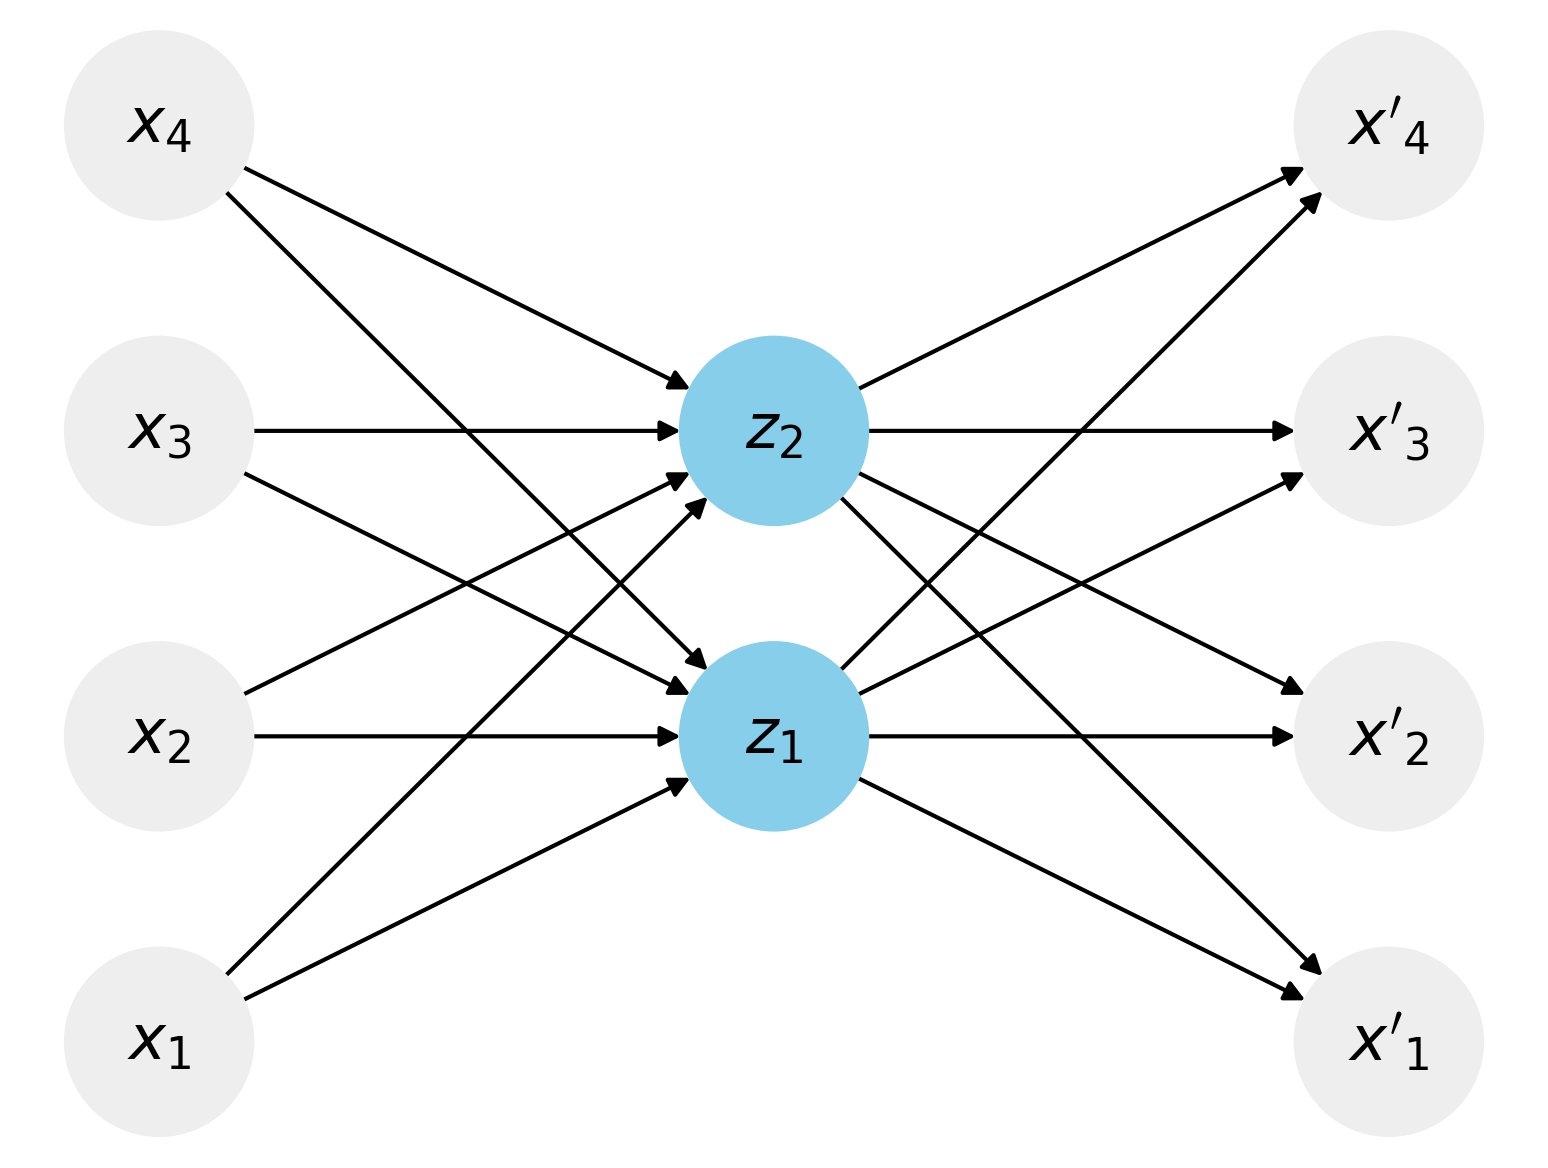

In [ ]:
G = nx.DiGraph()
G.add_nodes_from([
    'x1', 'x2', 'x3', 'x4',
    'z1', 'z2',
    "x'1", "x'2", "x'3", "x'4"
])
G.add_edges_from([
    ('x1', 'z1'), ('x1', 'z2'),
    ('x2', 'z1'), ('x2', 'z2'),
    ('x3', 'z1'), ('x3', 'z2'),
    ('x4', 'z1'), ('x4', 'z2'),
    ('z1', "x'1"), ('z2', "x'1"),
    ('z1', "x'2"), ('z2', "x'2"),
    ('z1', "x'3"), ('z2', "x'3"),
    ('z1', "x'4"), ('z2', "x'4"),
])

labels = {n: f"${n[:-1]}_{n[-1]}$" for n in G.nodes()}
pos = {
    'x1': (0, 0), 'x2': (0, 1), 'x3': (0, 2), 'x4': (0, 3),
    'z1': (1, 1), 'z2': (1, 2),
    "x'1": (2, 0), "x'2": (2, 1), "x'3": (2, 2), "x'4": (2, 3),
}
node_colors = ['skyblue' if n.startswith('z') else '#eee' for n in G.nodes()]
ax = plt.subplot(111)
nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
        node_color=node_colors, font_size=15, arrows=True, ax=ax)